<a href="https://colab.research.google.com/github/alessandronicolini/IncrementalLearning/blob/main/Deepinversion_immagini_create_una_volta_sola_partendo_da_exemplars_di_icarl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip3 install 'import_ipynb'
!pip3 install 'tqdm'

!rm -r IncrementalLearning
# upload work files from your git hub repository
import sys

!git clone https://github.com/alessandronicolini/IncrementalLearning.git # clone proj repository
!rm -rf IncrementalLearning/README.md 
!rm -rf IncrementalLearning/baselines.ipynb

path = 'IncrementalLearning/'
if path not in sys.path:
    sys.path.append('IncrementalLearning/')

!pip3 install import_ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=93939ca70c76d7244981f5129895099c5a50ac88dd8f5ce3e445e9f1e18628ef
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb
rm: cannot remove 'IncrementalLearning': No such file or directory
Cloning into 'IncrementalLearning'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 812 (delta 76), reused 0 (delta 0), pack-reused 667
Receiving objects: 100% (812/812), 7.32 MiB | 14.34 MiB/s, done.
Resolving deltas: 100% (477/477), done.


In [3]:
import numpy as np
import torch
from torchvision import transforms
from torchvision.datasets import VisionDataset
from PIL import Image
import random
import torchvision
ROOT = './data'
class ilCIFAR100(VisionDataset):
    """
    Extends CIFAR100 class. Split the dataset into 10 batches, each one containing 10 classes.
    You can retrieve the batches from the attribute "batches", it has different structure according to
    test and train CIFAR100 splits:
        - train -> batches is a dictionary {0:{'train':indexes, 'val':indexes}...} 
        - test -> batches is a dictionary {0:indexes...}
    where the keys are the batch number.

    Args:
        root (string): Root directory of dataset where directory
            `cifar-10-batches-py` exists or will be saved to if download is set to True.
        seed(int): used to ensure reproducibility in shuffling operations.
        val_size(float, optional): between 0 and 1, fraction of data used for validation.
        train (bool, optional): If True, creates dataset from training set, otherwise
            creates from test set.
        transform (callable, optional): A function/transform that takes in an PIL image
            and returns a transformed version. E.g, `transforms.RandomCrop`
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
    """
    def __init__(self,classes_per_batch, seed, val_size=0.1, train=True, transform=None, target_transform=False, 
    download=True):
        
        super(ilCIFAR100, self).__init__(root=0)
        self.classes_per_batch=classes_per_batch

        
        self.__rs = seed # set random seed 
        self.train=train
        self.__transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
        ])

        self.__transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
        ])
        # if train:
        #     self.batches = self.__make_train_batches(val_size)
        # else:
        #     self.batches = self.__make_test_batches()
        if self.train == 'train':
          self.dataset = torchvision.datasets.CIFAR100(root=ROOT, train=True,
                                            download=True, transform=self.__transform_train)
        elif self.train == 'exemplars':
          self.dataset = torchvision.datasets.CIFAR100(root=ROOT, train=True,
                                            download=True, transform=self.__transform_test)
        else:
          self.dataset = torchvision.datasets.CIFAR100(root=ROOT, train=False,
                                        download=True, transform=self.__transform_test)
          
        self.targets = np.array(self.dataset.targets) # make targets an array to exploit masking
        random.seed(seed)
        self.classes = random.sample(range(0, 100), 100)
        #self.classes = self.classes.reshape((10, -1)) # each row contains the classes for the corrisponding batch
        #print(self.classes)
        self.__dictionary = {}
        for i, c in enumerate(self.classes):
          self.__dictionary[c] = i


    def get_dict(self):
      return self.__dictionary
    def __getitem__(self, index):
        return index,self.dataset.__getitem__(index)[0],self.dataset.__getitem__(index)[1]
    def __len__(self):
        return self.dataset.__len__()
    def getbatches(self):
      classlist=self.classes
      batches=[]
      for i in range(0,int(100/self.classes_per_batch)):
        #print(i)
        batch=classlist[int(i*self.classes_per_batch):int(i*10+self.classes_per_batch)]
        batches.append(batch)
      return batches
    def get_batch_indexes(self):
      classlist=self.classes
      numclass=self.classes_per_batch
      batch_indexes=[]
      for i in range(0,int(100/self.classes_per_batch)):
        batch=classlist[int(i*numclass):int(i*numclass+numclass)]
        mask=np.isin(self.targets,batch)
        indexes=np.array(np.arange(len(self.dataset.targets)))
        indexes=indexes[mask]
        batch_indexes.append(indexes)
      return batch_indexes
    def get_class_indexes(self,label):
      indexes = np.array(np.arange(len(self.dataset.targets)))
      labels = self.dataset.targets
      mask = np.isin(labels, label)
      indexes = indexes[mask]

      return indexes
    def get_train_val(self,valid):
      batches=self.get_batch_indexes()
      train=[]
      val=[]
      for batch in batches:
        #print(type(batch))
        random.shuffle(batch)
        valbatch=batch[0:int(valid*len(batch))]
        trainbatch=batch[int(valid*len(batch)):]
        train.append(trainbatch)
        val.append(valbatch)
      return train,val
import torch
import torch.optim as optim
import torchvision
import time
import os
import argparse
import numpy as np

def tensor2im(input_image, imtype=np.uint8):
    #CIFAR100
    mean = [0.5071, 0.4867, 0.4408] 
    std = [0.2675, 0.2565, 0.2761]
    #CIFAR10
    #mean = [0.4914, 0.4822, 0.4465]
    #std = [0.2023, 0.1994, 0.2010]
    if not isinstance(input_image, np.ndarray):
        if isinstance(input_image, torch.Tensor):
            image_tensor = input_image.data
        else:
            return input_image
        image_numpy = image_tensor.cpu().detach().float().numpy()
        if image_numpy.shape[0] == 1:
            image_numpy = np.tile(image_numpy, (3, 1, 1))
        for i in range(len(mean)): 
            image_numpy[i] = image_numpy[i] * std[i] + mean[i]
        image_numpy = image_numpy * 255
        image_numpy = np.transpose(image_numpy, (1, 2, 0))
    else:
        image_numpy = input_image
    return image_numpy.astype(imtype)

In [4]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
from PIL import Image
import torchvision
import torchvision.transforms as transforms
import math
from sklearn.preprocessing import normalize
import copy
import torchvision.datasets as dsets
import torchvision.models as models
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from torch.utils.data import Subset, DataLoader, Dataset
import random
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd

import import_ipynb
#from IncrementalLearning.cifar100 import ilCIFAR100

from IncrementalLearning.resnet_cifar import resnet32
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

importing Jupyter notebook from /content/IncrementalLearning/resnet_cifar.ipynb


In [48]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import argparse
import random
import torch
import torch.nn as nn
# import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
# import torch.utils.data
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision.transforms as transforms

import numpy as np
import os
import glob
import collections

#from resnet_cifar import ResNet34, ResNet18

try:
    from apex.parallel import DistributedDataParallel as DDP
    from apex import amp, optimizers
    USE_APEX = True
except ImportError:
    print("Please install apex from https://www.github.com/nvidia/apex to run this example.")
    print("will attempt to run without it")
    USE_APEX = False

#provide intermeiate information
debug_output = False
debug_output = True


class DeepInversionFeatureHook():
    '''
    Implementation of the forward hook to track feature statistics and compute a loss on them.
    Will compute mean and variance, and will use l2 as a loss
    '''

    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        # hook co compute deepinversion's feature distribution regularization
        nch = input[0].shape[1]

        mean = input[0].mean([0, 2, 3])
        var = input[0].permute(1, 0, 2, 3).contiguous().view([nch, -1]).var(1, unbiased=False)

        # forcing mean and variance to match between two distributions
        # other ways might work better, e.g. KL divergence
        r_feature = torch.norm(module.running_var.data.type(var.type()) - var, 2) + torch.norm(
            module.running_mean.data.type(var.type()) - mean, 2)

        self.r_feature = r_feature
        # must have no output

    def close(self):
        self.hook.remove()

def get_images(net, bs=256, epochs=1000, idx=-1, var_scale=0.00005, competitive_scale=0.01,
               net_student=None, prefix=None, train_writer = None, global_iteration=None,
               use_amp=False, bn_reg_scale = 0.0,
               optimizer = None, inputs = None, labels = False, l2_coeff=0.0):
    '''
    Function returns inverted images from the pretrained model, parameters are tight to CIFAR dataset
    args in:
        net: network to be inverted
        bs: batch size
        epochs: total number of iterations to generate inverted images, training longer helps a lot!
        idx: an external flag for printing purposes: only print in the first round, set as -1 to disable
        var_scale: the scaling factor for variance loss regularization. this may vary depending on bs
            larger - more blurred but less noise
        net_student: model to be used for Adaptive DeepInversion
        prefix: defines the path to store images
        competitive_scale: coefficient for Adaptive DeepInversion
        train_writer: tensorboardX object to store intermediate losses
        global_iteration: indexer to be used for tensorboard
        use_amp: boolean to indicate usage of APEX AMP for FP16 calculations - twice faster and less memory on TensorCores
        optimizer: potimizer to be used for model inversion
        inputs: data place holder for optimization, will be reinitialized to noise
        bn_reg_scale: weight for r_feature_regularization
        random_labels: sample labels from random distribution or use columns of the same class
        l2_coeff: coefficient for L2 loss on input
    return:
        A tensor on GPU with shape (bs, 3, 32, 32) for CIFAR
    '''

    kl_loss = nn.KLDivLoss(reduction='batchmean').cuda()

    # preventing backpropagation through student for Adaptive DeepInversion
    net_student.train()

    best_cost = 1e6

    # initialize gaussian inputs
    inputs.data = inputs.to('cuda')
    # if use_amp:
    #     inputs.data = inputs.data.half()

    # set up criteria for optimization
    criterion = nn.CrossEntropyLoss()

    optimizer.state = collections.defaultdict(dict)  # Reset state of optimizer

    # target outputs to generate
    #if labels:
    targets = labels
    #else:
     #   targets = torch.LongTensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9] * 25 + [0, 1, 2, 3, 4, 5]).to('cuda')

    outputs=net(inputs.data)
    _, predicted_teach = outputs.max(1)

    outputs_student=net_student(inputs.data)
    _, predicted_std = outputs_student.max(1)

    if idx == 0:
        print('Teacher correct out of {}: {}, loss at {}'.format(bs, predicted_teach.eq(targets).sum().item(), criterion(outputs, targets).item()))
        print('Student correct out of {}: {}, loss at {}'.format(bs, predicted_std.eq(targets).sum().item(), criterion(outputs_student, targets).item()))

    ## Create hooks for feature statistics catching
    loss_r_feature_layers = []
    for module in net.modules():
        if isinstance(module, nn.BatchNorm2d):
            loss_r_feature_layers.append(DeepInversionFeatureHook(module))

    # setting up the range for jitter
    lim_0, lim_1 = 2, 2

    for epoch in tqdm(range(epochs)):
        # apply random jitter offsets
        off1 = random.randint(-lim_0, lim_0)
        off2 = random.randint(-lim_1, lim_1)
        inputs_jit = torch.roll(inputs, shifts=(off1,off2), dims=(2,3))

        # foward with jit images
        optimizer.zero_grad()
        net.zero_grad()
        outputs = net(inputs_jit)
        loss = criterion(outputs, targets)
        loss_target = loss.item()

        # competition loss, Adaptive DeepInvesrion
        if competitive_scale != 0.0:
            net_student.zero_grad()
            outputs_student = net_student(inputs_jit)
            T = 3.0

            if 1:
                # jensen shanon divergence:
                # another way to force KL between negative probabilities
                P = F.softmax(outputs_student / T, dim=1)
                Q = F.softmax(outputs / T, dim=1)
                M = 0.5 * (P + Q)

                P = torch.clamp(P, 0.01, 0.99)
                Q = torch.clamp(Q, 0.01, 0.99)
                M = torch.clamp(M, 0.01, 0.99)
                eps = 0.0
                # loss_verifier_cig = 0.5 * kl_loss(F.log_softmax(outputs_verifier / T, dim=1), M) +  0.5 * kl_loss(F.log_softmax(outputs/T, dim=1), M)
                loss_verifier_cig = 0.5 * kl_loss(torch.log(P + eps), M) + 0.5 * kl_loss(torch.log(Q + eps), M)
                # JS criteria - 0 means full correlation, 1 - means completely different
                loss_verifier_cig = 1.0 - torch.clamp(loss_verifier_cig, 0.0, 1.0)

                loss = loss + competitive_scale * loss_verifier_cig

        # apply total variation regularization
        diff1 = inputs_jit[:,:,:,:-1] - inputs_jit[:,:,:,1:]
        diff2 = inputs_jit[:,:,:-1,:] - inputs_jit[:,:,1:,:]
        diff3 = inputs_jit[:,:,1:,:-1] - inputs_jit[:,:,:-1,1:]
        diff4 = inputs_jit[:,:,:-1,:-1] - inputs_jit[:,:,1:,1:]
        loss_var = torch.norm(diff1) + torch.norm(diff2) + torch.norm(diff3) + torch.norm(diff4)
        loss = loss + var_scale*loss_var

        # R_feature loss
        loss_distr = sum([mod.r_feature for mod in loss_r_feature_layers])
        loss = loss + bn_reg_scale*loss_distr # best for noise before BN

        # l2 loss
        if 1:
            loss = loss + l2_coeff * torch.norm(inputs_jit, 2)

        if debug_output and epoch % 200==0:
            print(f"It {epoch}\t Losses: total: {loss.item():3.3f},\ttarget: {loss_target:3.3f} \tR_feature_loss unscaled:\t {loss_distr.item():3.3f}")
            #vutils.save_image(inputs.data.clone(),
             #                 './{}/output_{}.png'.format(prefix, epoch//200),
              #                normalize=True, scale_each=True, nrow=10)

        if best_cost > loss.item():
            best_cost = loss.item()
            best_inputs = inputs.data

        # backward pass
        if use_amp:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()

        optimizer.step()

    outputs=net(best_inputs)
    _, predicted_teach = outputs.max(1)

    outputs_student=net_student(best_inputs)
    _, predicted_std = outputs_student.max(1)

    if idx == 0:
        print('Teacher correct out of {}: {}, loss at {}'.format(bs, predicted_teach.eq(targets).sum().item(), criterion(outputs, targets).item()))
        print('Student correct out of {}: {}, loss at {}'.format(bs, predicted_std.eq(targets).sum().item(), criterion(outputs_student, targets).item()))

    name_use = "best_images"
    if prefix is not None:
        name_use = prefix + name_use
    next_batch = len(glob.glob("./%s/*.png" % name_use)) // 1

    #vutils.save_image(best_inputs[:20].clone(),
     #                 './{}/output_{}.png'.format(name_use, next_batch),
      #                normalize=True, scale_each = True, nrow=10)

    #if train_writer is not None:
     #   train_writer.add_scalar('gener_teacher_criteria', criterion(outputs, targets), global_iteration)
      #  train_writer.add_scalar('gener_student_criteria', criterion(outputs_student, targets), global_iteration)

       # train_writer.add_scalar('gener_teacher_acc', predicted_teach.eq(targets).sum().item() / bs, global_iteration)
       # train_writer.add_scalar('gener_student_acc', predicted_std.eq(targets).sum().item() / bs, global_iteration)

        #train_writer.add_scalar('gener_loss_total', loss.item(), global_iteration)
        #train_writer.add_scalar('gener_loss_var', (var_scale*loss_var).item(), global_iteration)

    net_student.train()

    return best_inputs

Please install apex from https://www.github.com/nvidia/apex to run this example.
will attempt to run without it


In [49]:
class mnemonics():
  def __init__(self, randomseed):
    self.device = 'cuda'
    self.model = resnet32(num_classes=100).to(self.device)
    self.feature_extractor = self.model.features
    self.temp_model = None
    self.lr = 2
    self.gamma = 0.2
    self.weight_decay = 1e-5 
    self.milestones = [49,63]
    self.batch_size = 128
    self.numepochs = 70
    self.n_classes = 0
    self.n_known = 0
    self.feature_size=64
    self.momentum=0.9
    self.criterion = nn.BCEWithLogitsLoss()

    self.NUM_BATCHES=10
    self.randomseed=randomseed
    self.trainloader=None
    self.testloader=None
    self.CLASSES_PER_BATCH=10

    self.original_training_set = ilCIFAR100(self.CLASSES_PER_BATCH, self.randomseed, train = 'train')
    self.original_exemplar_set = ilCIFAR100(self.CLASSES_PER_BATCH, self.randomseed, train = 'exemplars')
    self.original_test_set = ilCIFAR100(self.CLASSES_PER_BATCH,self.randomseed, train= 'test')

    self.last_test = None
    self.y_pred = []
    self.y_test = []

    self.cumulative_class_mean = []
    self.exemplar_sets = []

    self.classes_seen=0
    self.diz = self.original_training_set.get_dict()
    self.fake_diz = {}
    for key, value in self.diz.items():
      self.fake_diz[value] = key

  def modification_of_random_exemplars(self, indexes, n_epochs):
    # CODICE PER CREARE LE IMMAGINI SINTETICHE, ORA ME LE CREO VOLTA PER VOLTA, QUINDI AD OGNI BATCH DIMENTICO QUELLE GIA FATTE E NE CREO NUOVE
    print('len of task:', len(indexes))

    inputs_dataset = torch.zeros((len(indexes),3,32,32))
    labels_of_modified = torch.zeros(len(indexes), dtype = int).to(self.device)

    for i, el in enumerate(indexes):
      inputs_dataset[i,:,:,:] = self.original_exemplar_set.__getitem__(el)[1]
      labels_of_modified[i] = self.diz[self.original_exemplar_set.__getitem__(el)[2]]


    number_of_images_created = len(indexes)
    teacher = copy.deepcopy(self.model)
    net_teacher = resnet32(num_classes=100).to(self.device)
    net_teacher.load_state_dict(teacher.state_dict())
    net_teacher.eval()

    net_student = resnet32(num_classes=100).to(self.device)

    inputs_dataset = torch.tensor(inputs_dataset.data, requires_grad=True, dtype = torch.float, device = self.device)
    #inputs_dataset = torch.randn((len(indexes), 3, 32, 32), requires_grad=True, device='cuda', dtype=torch.float)

    plt.imshow(tensor2im(inputs_dataset[0]))
    plt.show()

    train_writer = None  # tensorboard writter
    global_iteration = 0
    di_lr = 0.05
    optimizer_di = optim.Adam([inputs_dataset], lr=di_lr)

    batch_idx = 0
    inputs = get_images(net=net_teacher, bs=len(labels_of_modified), epochs=n_epochs, idx=batch_idx, 
                      net_student=net_student, competitive_scale=10.0, l2_coeff = 3e-8, bn_reg_scale = 1.0,
                      train_writer=train_writer, use_amp=False,
                      optimizer=optimizer_di, inputs=inputs_dataset, 
                      var_scale=2e-5, labels=labels_of_modified) #2.5e-5

    inputs_data = inputs.data.clone().detach()
    plt.imshow(tensor2im(inputs_data[0]))
    plt.show()
    labels = torch.tensor([self.fake_diz[c.item()] for c in labels_of_modified])

    for i, el in enumerate(indexes):
      self.original_exemplar_set.dataset.data[el] = tensor2im(inputs_data[i]) 
      self.original_exemplar_set.dataset.targets[el] = int(labels[i])

  def model_level_optimization(self):
    
    old_model = copy.deepcopy(self.model)
    old_model.eval()
    old_model.to(self.device)
    n_classes = self.classes_seen+self.CLASSES_PER_BATCH
    print(n_classes)
    optimizer = optim.SGD(self.model.parameters(), lr=self.lr, momentum=self.momentum, weight_decay=self.weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=self.milestones, gamma=self.gamma)
    for epoch in tqdm(range(self.numepochs)):
        
      for _, inputs, labels in self.trainloader:

        inputs = inputs.float().to(self.device)
        labels = torch.tensor([self.diz[c.item()] for c in labels])

        labels=labels.to(self.device)
        optimizer.zero_grad()
        outputs=self.model(inputs)

        labels_encoded = F.one_hot(labels,100).float().to(self.device) #CAMBIARE ONE_HOT
        
        if self.classes_seen:
          old_target = old_model(inputs).to(self.device)
          old_target = torch.sigmoid(old_target).to(self.device)
          
          target = torch.cat((old_target[:,:self.classes_seen], labels_encoded[:, self.classes_seen:]), dim=1)
          loss = self.criterion(outputs, target)
        else:
          loss = self.criterion(outputs, labels_encoded) 

        loss.backward()
        optimizer.step()
      
      scheduler.step()

  def classify_nme(self, input_batch):
    min_distances = float('inf')*torch.ones(len(input_batch)).to(self.device) # shape: batch_size --> 128
    y_pred = torch.zeros(len(input_batch), dtype=torch.int8).to(self.device) # shape: batch_size --> 128
    input_features = self.model.features(input_batch) # shape: (batch_size, feature_size) --> (128, 64)

    for i in range(len(self.exemplar_sets_idxs)):
      ex_mean = self.exemplar_means[i,:]

      # compute distances between inputs features and exemplar set means
      pdist = nn.PairwiseDistance(p=2)
      distances = pdist(input_features, ex_mean) # shape: batch_size --> 128

      # update min distancies and predicted labels
      mask = distances < min_distances
      min_distances[mask] = distances[mask]
      y_pred[mask] = self.exemplar_labels[i]

    return y_pred
    

  def get_new_exemplars(self, batch, m):
    loader = torch.utils.data.DataLoader(batch, batch_size=self.batch_size,shuffle=False, num_workers=4)
    features = np.zeros((0,self.feature_size))
    indices = np.zeros((0), dtype=int)
    with torch.no_grad():
      for indexes, images, labels in loader:
        images = images.cuda()
        feature = self.feature_extractor(images).data.cpu().numpy()
        feature = normalize(feature, axis=1, norm='l2')
        features = np.concatenate((features,feature), axis=0)
        indices = np.concatenate((indices,indexes), axis=0)

    class_mean = np.mean(features, axis=0)
    class_mean = class_mean / np.linalg.norm(class_mean)  # Normalize

    exemplar_set = []
    exemplar_features = np.zeros((0,self.feature_size))

    for k in range(1, int(m)+1):
        S = np.sum(exemplar_features, axis=0)
        phi = features
        mu = class_mean
        mu_p = 1.0 / k * (phi + S)
        mu_p = normalize(mu_p, axis=1, norm='l2')
        i = np.argmin(np.sqrt(np.sum((mu - mu_p) ** 2, axis=1)))
        exemplar_set.append(indices[i])
        addfeature =  np.expand_dims(features[i], axis=0)
        exemplar_features = np.concatenate((exemplar_features,addfeature), axis=0)

        #remove duplicates
        features = np.delete(features, i, 0)
        indices = np.delete(indices, i, 0)
        
    self.exemplar_sets.append(exemplar_set)


  def reduce_old_exemplars(self, m):
    for i, set_i in enumerate(self.exemplar_sets_idxs):
      self.exemplar_sets_idxs[i] = random.sample(set_i, m)

  def __accuracy_fc(self, dl, mapper):
    total = 0.0
    correct = 0.0
    for  _, images, labels in dl:
      labels = torch.tensor([torch.tensor(mapper[c.item()]) for c in labels])
      labels = labels.to(self.device)
      images = images.to(self.device)
      outputs = self.model(images)
      _, preds = torch.max(outputs, dim=1)
      total += len(labels)
      correct += torch.sum(preds == labels).item()

    acc = correct / total
    return acc


  def __accuracy_nme(self, dl):
    
    total = 0.0
    correct = 0.0
    
    for  _, images, labels in dl:
      labels = labels.to(self.device)
      images = images.to(self.device)
      preds = self.classify_nme(images)
      total += len(labels)
      correct += torch.sum(preds == labels).item()

      if self.last_test:
        self.y_pred += preds.tolist()
        self.y_test += labels.tolist()

    acc = correct / total
    return acc


  def plot_confusion_matrix(self):
 
    cm = confusion_matrix(self.y_test, self.y_pred)
    cm = np.log(cm+1)
    fig, ax = plt.subplots(figsize=(7,7))
    sns.heatmap(cm, square=True, cbar=False, ax=ax, cmap=plt.get_cmap('seismic'))
    ax.set_xticks(np.linspace(19,99,5))
    ax.set_yticks(np.linspace(19,99,5))
    ax.set_xticklabels([20,40,60,80,100], rotation=0)
    ax.set_yticklabels([20,40,60,80,100], rotation=0)
    ax.set_title("iCaRL")
    ax.set_xlabel("Predicted class")
    ax.set_ylabel("True class")
    plt.savefig("iCaRL_"+str(self.randomseed)+"_cm.png")
    plt.show()
    return cm


  def trainer(self):
    
    train_indices = self.original_training_set.get_batch_indexes()
    test_indices = self.original_test_set.get_batch_indexes()
    batches=self.original_training_set.getbatches()
    current_test_indexes=[]
    test_acc = []
    incremental_classes_label = np.array([])
    self.last_test = False

    n_epochs = 300 #NUMERO DI ITERAZIONI PER GENERARE IMMAGINI

    for i in range(self.NUM_BATCHES):
      print('current batches', batches[i])
      if i == self.NUM_BATCHES-1:
        self.last_test = True

      train_dataset = Subset(self.original_training_set, train_indices[i])
      current_test_indexes += test_indices[i].tolist()
      test_dataset = Subset(self.original_test_set,current_test_indexes)
      self.train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4, drop_last=True)
      self.testloader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4, drop_last=True)        
      

      if i == 0:
        self.trainloader = self.train_loader
      else:
        exemplar_dataset = Subset(self.original_exemplar_set, exemplars_momentanei)
        new_dataset = torch.utils.data.ConcatDataset((train_dataset, exemplar_dataset))
        self.trainloader = torch.utils.data.DataLoader(new_dataset, batch_size=128, shuffle=True, num_workers=4, drop_last = True)#, pin_memory=True)

      self.model.train()
      self.model_level_optimization()    
      self.classes_seen += 10
      self.model.eval() # Set Network to evaluation mode


      print('accuracy on training set:', 100*self.__accuracy_fc(self.trainloader,self.diz))
      current_test_acc = self.__accuracy_fc(self.testloader, self.diz)
      print('accuracy on test set:', 100*current_test_acc)
      print('-' * 80)

      if i != 9: 
        indici_da_tenere = []
        m=int(2000/(int(i*10+10)))

        for classlabel in batches[i]: #get exemplars as icarl
          indexes_class = self.original_training_set.get_class_indexes(classlabel)
          current_class = Subset(self.original_training_set, indexes_class)
          self.get_new_exemplars(current_class, m)

        if i!=0:
          for el in lista_di_liste_degli_exemplars: #RIDUCO IL NUMERO DI EXEMPLARS
            indici_da_tenere.append(el[:m])

        exemplars_momentanei = np.array(np.reshape(indici_da_tenere, (-1)), dtype = int)

        images_task_1 = np.array([], dtype = int)
        images_task_2 = np.array([], dtype = int)
        images_task_3 = np.array([], dtype = int)
        lista_di_liste_degli_exemplars = indici_da_tenere

        for random_images in self.exemplar_sets[-10:]:
          exemplars_momentanei = np.concatenate((exemplars_momentanei, random_images))
          lista_di_liste_degli_exemplars.append(random_images)
          if m*10> 1300:
            images_task_1 = np.concatenate((images_task_1, random_images[:int(m/3)]))
            images_task_2 = np.concatenate((images_task_2, random_images[int(m/3):2*(int(m/3))]))
            images_task_3 = np.concatenate((images_task_3, random_images[2*(int(m/3)):]))
          elif m*10>700:
            images_task_1 = np.concatenate((images_task_1, random_images[:int(m/2)]))
            images_task_2 = np.concatenate((images_task_2, random_images[int(m/2):2*(int(m/2))]))
          else:
            images_task_1 = np.concatenate((images_task_1, random_images))
        
        self.modification_of_random_exemplars(images_task_1, n_epochs)
        if m*10>700:
          self.modification_of_random_exemplars(images_task_2, n_epochs)
        if m*10>1300:
          self.modification_of_random_exemplars(images_task_3, n_epochs)

        print('len exemplars momentanei', len(exemplars_momentanei))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
current batches [11, 5, 62, 76, 27, 3, 96, 33, 78, 30]
10



accuracy on training set: 98.41746794871796
accuracy on test set: 85.04464285714286
--------------------------------------------------------------------------------
len of task: 660


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


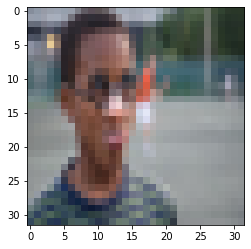

Teacher correct out of 660: 657, loss at 0.008029759861528873
Student correct out of 660: 0, loss at 5.256422996520996


It 0	 Losses: total: 66.040,	target: 0.030 	R_feature_loss unscaled:	 61.153
It 200	 Losses: total: 35.107,	target: 0.010 	R_feature_loss unscaled:	 31.509

Teacher correct out of 660: 660, loss at 0.0021325869020074606
Student correct out of 660: 0, loss at 5.1906256675720215


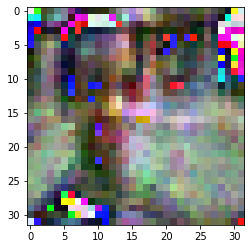

len of task: 660


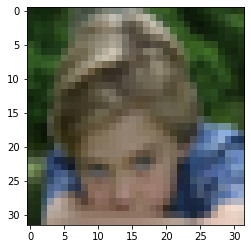

Teacher correct out of 660: 659, loss at 0.00869990698993206
Student correct out of 660: 38, loss at 4.7391581535339355


It 0	 Losses: total: 62.363,	target: 0.016 	R_feature_loss unscaled:	 57.499
It 200	 Losses: total: 17.861,	target: 0.018 	R_feature_loss unscaled:	 12.705

Teacher correct out of 660: 656, loss at 0.02320571057498455
Student correct out of 660: 43, loss at 4.809952259063721


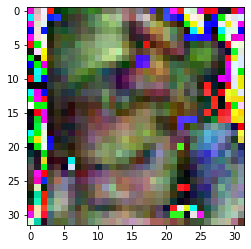

len of task: 680


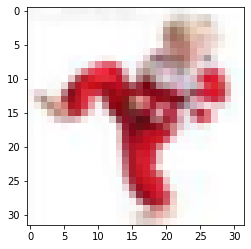

Teacher correct out of 680: 679, loss at 0.00635280879214406
Student correct out of 680: 0, loss at 4.679513931274414


It 0	 Losses: total: 63.003,	target: 0.018 	R_feature_loss unscaled:	 58.094
It 200	 Losses: total: 15.452,	target: 0.023 	R_feature_loss unscaled:	 10.836

Teacher correct out of 680: 669, loss at 0.059728991240262985
Student correct out of 680: 0, loss at 4.702172756195068


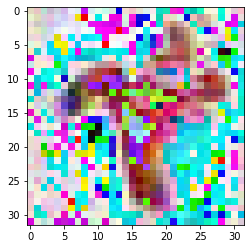

len exemplars momentanei 2000
current batches [2, 31, 44, 82, 12, 16, 15, 13, 71, 87]
20



accuracy on training set: 88.25231481481481
accuracy on test set: 68.48958333333334
--------------------------------------------------------------------------------
len of task: 500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


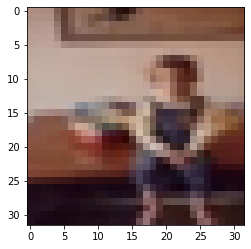

Teacher correct out of 500: 481, loss at 0.11056340485811234
Student correct out of 500: 0, loss at 5.368738651275635


It 0	 Losses: total: 43.966,	target: 0.151 	R_feature_loss unscaled:	 37.894
It 200	 Losses: total: 20.929,	target: 0.098 	R_feature_loss unscaled:	 15.586

Teacher correct out of 500: 480, loss at 0.1380646824836731
Student correct out of 500: 0, loss at 5.155457973480225


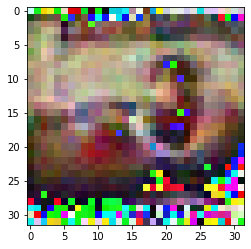

len of task: 500


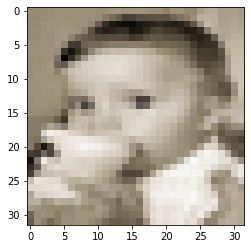

Teacher correct out of 500: 485, loss at 0.08944760262966156
Student correct out of 500: 0, loss at 4.664251327514648


It 0	 Losses: total: 46.430,	target: 0.161 	R_feature_loss unscaled:	 40.341
It 200	 Losses: total: 15.047,	target: 0.234 	R_feature_loss unscaled:	 8.563

Teacher correct out of 500: 485, loss at 0.10706322640180588
Student correct out of 500: 0, loss at 4.683873176574707


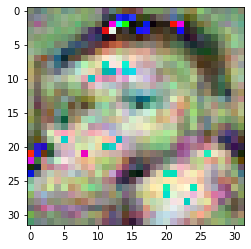

len exemplars momentanei 2000
current batches [73, 92, 75, 48, 56, 25, 63, 86, 38, 9]
30



accuracy on training set: 82.23379629629629
accuracy on test set: 58.32201086956522
--------------------------------------------------------------------------------
len of task: 660


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


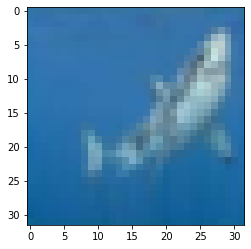

Teacher correct out of 660: 632, loss at 0.12237212806940079
Student correct out of 660: 0, loss at 5.236134052276611


It 0	 Losses: total: 39.508,	target: 0.214 	R_feature_loss unscaled:	 32.635
It 200	 Losses: total: 12.959,	target: 0.202 	R_feature_loss unscaled:	 6.524

Teacher correct out of 660: 650, loss at 0.07955238223075867
Student correct out of 660: 0, loss at 5.200752258300781


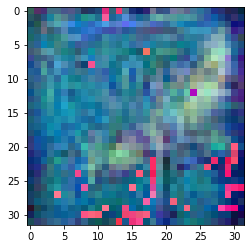

len exemplars momentanei 1980
current batches [58, 69, 91, 22, 83, 89, 93, 51, 81, 8]
40



accuracy on training set: 78.87731481481481
accuracy on test set: 52.21774193548387
--------------------------------------------------------------------------------
len of task: 500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


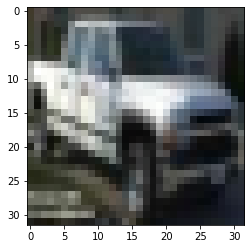

Teacher correct out of 500: 480, loss at 0.14159999787807465
Student correct out of 500: 0, loss at 5.104582786560059


It 0	 Losses: total: 46.015,	target: 0.199 	R_feature_loss unscaled:	 38.735
It 200	 Losses: total: 14.574,	target: 0.205 	R_feature_loss unscaled:	 8.215

Teacher correct out of 500: 497, loss at 0.08786460012197495
Student correct out of 500: 0, loss at 5.115145683288574


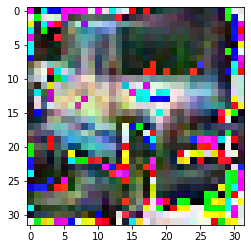

len exemplars momentanei 2000
current batches [90, 32, 55, 23, 4, 40, 54, 59, 18, 43]
50



accuracy on training set: 76.5480324074074
accuracy on test set: 43.18910256410257
--------------------------------------------------------------------------------
len of task: 400


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


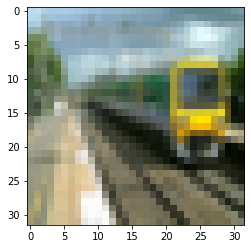

Teacher correct out of 400: 377, loss at 0.19848507642745972
Student correct out of 400: 0, loss at 4.869845867156982


It 0	 Losses: total: 56.194,	target: 0.198 	R_feature_loss unscaled:	 48.434
It 200	 Losses: total: 22.191,	target: 0.132 	R_feature_loss unscaled:	 15.924

Teacher correct out of 400: 386, loss at 0.14128589630126953
Student correct out of 400: 0, loss at 4.820953845977783


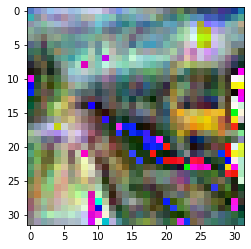

len exemplars momentanei 2000
current batches [95, 21, 53, 20, 94, 14, 99, 64, 47, 60]
60



accuracy on training set: 76.76504629629629
accuracy on test set: 40.625
--------------------------------------------------------------------------------
len of task: 330


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


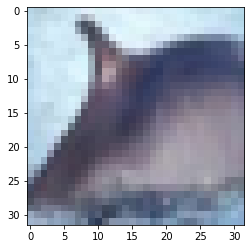

Teacher correct out of 330: 315, loss at 0.16056644916534424
Student correct out of 330: 0, loss at 4.589301109313965


It 0	 Losses: total: 46.202,	target: 0.220 	R_feature_loss unscaled:	 38.566
It 200	 Losses: total: 13.166,	target: 0.034 	R_feature_loss unscaled:	 7.585

Teacher correct out of 330: 329, loss at 0.03021804615855217
Student correct out of 330: 0, loss at 4.623389720916748


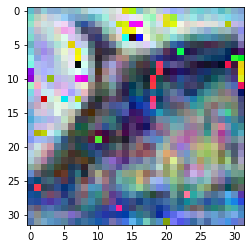

len exemplars momentanei 1980
current batches [98, 39, 57, 74, 72, 84, 34, 97, 88, 24]
70



accuracy on training set: 75.65104166666666
accuracy on test set: 37.28298611111111
--------------------------------------------------------------------------------
len of task: 280


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


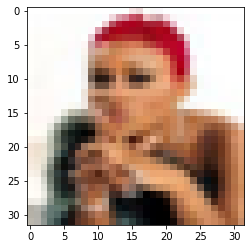

Teacher correct out of 280: 259, loss at 0.24374718964099884
Student correct out of 280: 0, loss at 5.070474624633789


It 0	 Losses: total: 57.046,	target: 0.280 	R_feature_loss unscaled:	 48.884
It 200	 Losses: total: 17.804,	target: 0.207 	R_feature_loss unscaled:	 10.853

Teacher correct out of 280: 272, loss at 0.12679839134216309
Student correct out of 280: 0, loss at 4.984830379486084


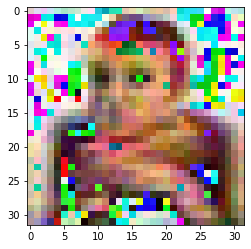

len exemplars momentanei 1960
current batches [77, 67, 42, 1, 61, 35, 46, 66, 29, 26]
80



accuracy on training set: 73.39409722222221
accuracy on test set: 32.18245967741936
--------------------------------------------------------------------------------
len of task: 250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


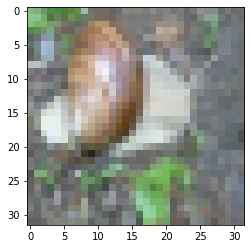

Teacher correct out of 250: 241, loss at 0.21696755290031433
Student correct out of 250: 16, loss at 5.021306991577148


It 0	 Losses: total: 50.634,	target: 0.628 	R_feature_loss unscaled:	 41.393
It 200	 Losses: total: 21.626,	target: 0.063 	R_feature_loss unscaled:	 15.529

Teacher correct out of 250: 245, loss at 0.08091548830270767
Student correct out of 250: 6, loss at 5.084343910217285


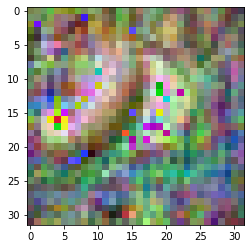

len exemplars momentanei 2000
current batches [65, 28, 79, 10, 37, 80, 36, 52, 50, 0]
90



accuracy on training set: 73.78472222222221
accuracy on test set: 29.508928571428573
--------------------------------------------------------------------------------
len of task: 220


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


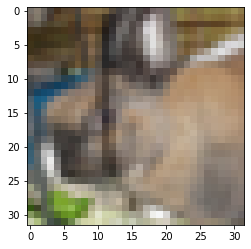

Teacher correct out of 220: 208, loss at 0.26810070872306824
Student correct out of 220: 7, loss at 5.000161647796631


It 0	 Losses: total: 57.199,	target: 0.597 	R_feature_loss unscaled:	 47.678
It 200	 Losses: total: 17.258,	target: 0.090 	R_feature_loss unscaled:	 10.006

Teacher correct out of 220: 219, loss at 0.04803873971104622
Student correct out of 220: 12, loss at 4.990154266357422


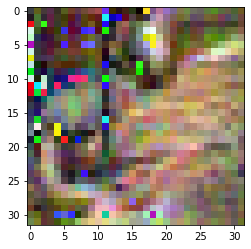

len exemplars momentanei 1980
current batches [45, 68, 6, 85, 70, 49, 17, 7, 19, 41]
100



accuracy on training set: 73.74131944444444
accuracy on test set: 27.854567307692307
--------------------------------------------------------------------------------


TypeError: ignored

In [50]:
method = mnemonics(randomseed=203)
model, batch = method.trainer()